<a href="https://colab.research.google.com/github/zanemit/images4in2scienceUK/blob/master/in2scienceUK2020_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating the neural mechanisms that makes us turn right or left

##Introduction to the tutorial

This tutorial is designed to supplement the 'Neuroscience of Locomotion' seminar by examining the neural circuits involved in left/right turning behaviour. The notebook will guide you through analysis of data modelled on a publication by the laboratory of Ole Kiehn (University of Copenhagen) earlier this year. 

The tutorial is written in Python and is thoroughly annotated, so prior coding experience is not required. However, you are encouraged to read through the code and try to understand the logic behind it. You can run the code by clicking on the 'play' button in the top left corner of each cell. 

As part of the tutorial, you will generate several plots and be asked to interpret them. Being able to make sense of data is an essential skill in science. Reading the background information that is provided throughout the tutorial may also be helpful. 

There are three tasks, each with associated questions in **bold**. Tasks 1 and 2 can be carried out by simply running the code. In Task 3, you will be asked to fill in a few blanks in the code. That should be possible by examining analogous pieces of code elsewhere in this notebook. 

The goals of this tutorial are:
* to give you an opportunity to think about, and engage in, science on a deep level
* to give you insight into the process of data analysis that neuroscientists face on an almost daily basis. 

The questions in this tutorial are NOT EASY! Some of them might even pose a challenge to senior undergraduate students, so you should not worry if you do not know the answers to some (or, indeed, any) of them! In fact, feeling puzzled and not having answers is part of being a scientist too!

Finally, please jot down any questions you have as you go through the tutorial, as you will be encouraged to ask them during the follow-up session.

## Setup and data retrieval
Run the cell below to:
* import the Python packages necessary for this tutorial: `numpy`, `pandas`, and `matplotlib` are some of the most widely used packages in science (and beyond)
* create a folder called `in2scienceTaskOutput` in our current working directory (`/content` in Colab by default, you can run `os.getcwd()` to check) for storing data and the plots we will generate
* set several `matplotlib` parameters to standardise the appearance of our plots
* download the data 

In [7]:
# import packages
import os
import numpy as np
import scipy.stats 
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt 
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
%matplotlib inline

# create a folder 
SPATH = "in2scienceTaskOutput/" #define folder name
!mkdir -p "{SPATH}" #makes the folder in our current working directory

# set matplotlib parameters
plt.rcParams['figure.dpi'] = 140
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.facecolor'] = (1,1,1,0)
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 12

# download and extract the data
!wget -nc -O "{SPATH}tutorial_data.zip" "https://ndownloader.figshare.com/files/23106284"
!unzip -d "{SPATH}" -n "{SPATH}tutorial_data.zip"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


--2020-06-12 18:16:45--  https://ndownloader.figshare.com/files/23106284
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 99.80.24.223, 34.246.9.175, 54.72.248.163, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|99.80.24.223|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/23106284/in2scienceUK_tutorial.zip [following]
--2020-06-12 18:16:45--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/23106284/in2scienceUK_tutorial.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.105.58
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.105.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9441 (9.2K) [application/zip]
Saving to: ‘in2scienceTaskOutput/tutorial_data.zip’

in2scienceTaskOutpu 100%[===================>]   9.22K  --.-KB/s    in 0s      

2020-06-12 18:16:46 (107 MB/s) - ‘in2sc

##Research context
In the seminar, we learned about midbrain neurons that initiate full-bodied locomotion in a straight line. Stimulating those neurons on one side of the brain activates spinal cord circuits bilaterally. In other words, it is a symmetric start command. 

A related question concerns our ability to direct our movement to the left or right side. One might imagine how such directional control could be achieved through asymmetric activation of the central pattern generators in the spinal cord. Indeed, experiments on reduced preparations, such as an extruded spinal cord in a dish, have supported the existence of such asymmetrically controllable modules. Furthermore, anatomical data have suggested a specific class of neurons in the gigantocellular nucleus (Gi) of the reticular formation as plausible generators of the aforementioned asymmetry. 

This provides a good starting point for experiments in awake, locomoting animals that could ultimately lead to a thorough understand of turning behaviours.

##Experiment 1: chemogenetic activation of specific Gi neurons

To investigate the role of genetically defined Gi neurons in turning behaviour, one can artificially activate those neurons using _chemogenetics_ as we saw in the seminar. Thus, the mouse was made to express a specific receptor (hM3Dq) selectively in the Gi neurons of interest on _one side_ (right side) of the brain. When activated by clozapine-N-oxide (CNO), this receptor excites the respective neurons, making them fire action potentials. 

CNO was delivered into the membrane lining the abdominal cavity (_intraperitoneally_). From there it can enter the bloodstream and reach the brain. In some sessions, the mouse was injected with saline instead of CNO.

In this experiment, a mouse was placed in an empty [cylindrical arena](https://raw.githubusercontent.com/zanemit/images4in2scienceUK/master/cylinder.jpg) and left to explore the arena for 60 minutes. The mouse was filmed from above to monitor its turning behaviour.


#### A note on data preprocessing
Video files were processed with a deep learning algorithm called _DeepLabCut_ that is routinely used in neuroscience to efficiently extract the xy coordinates of specific body parts. Here, we care about the xy coordinates of two body parts: nose `(Nx,Ny)` and tail base `(Tx,Ty)`.

Once the xy coordinates of those body parts were obtained, the position of body centre `(Bx,By)` was computed as the midpoint of the line segment between nose and tail base. 

This allows quantification of body orientation by considering the vector from the body centre to tail base `BT` in each camera frame. $$BT = (Bx-Tx,By-Ty)$$  Angular changes in body orientation can be calculated from the dot product of vectors `BT(t)` and `BT(t+1)`. $$cos\theta = \frac{BT(t)\cdot BT(t+1)}{\lvert BT(t)\rvert \cdot \lvert BT(t+1) \rvert}$$

A visual illustration of this process can be found [here](https://github.com/zanemit/images4in2scienceUK/blob/master/turning_angle.jpg?raw=true).

Now we have a list of angular changes in body orientation corresponding to each camera frame. Remember that our goal is to identify neural circuits that have a strong effect on turning behaviour. Therefore, it is convenient to discretise the data by setting a threshold for the angular change in body orientation that is to be considered a turn. Here we define this threshold as 50 degrees, and end up with three possible outcomes at every time point: 
* right turn (ipsilateral), $50° < \theta < 180°$, designated as `1` in the data
* left turn (contralateral), $-180° < \theta < -50°$, designated as `-1` in the data
* no turn $-50° < \theta < 50°$, designated as `0` in the data

Note that ipsi- and contra-lateral are defined relative to the side of the brain that we perturb with chemogenetics.

The data we use in this tutorial has already been preprocessed and discretised as described above. 

### Task 1: examine data from a single session
Here we load the data from one session with saline, and one session with CNO, in the same mouse (id: `167.3`). 

We examine the general structure of the data table by calling `head()`.

In [12]:
path = SPATH + "Gi_hM3Dq_167.3_3.csv" #define full path to file
df1 = pd.read_csv(path, sep = ';') #load data
df1.head() #print the first five rows

,time,turn_sal,turn_cno
0,0.016667,0,0
1,0.033333,0,0
2,0.050000,0,0
3,0.066667,0,0
4,0.083333,0,0


We have the timestamp of the camera frame (in minutes) and the turning outcome: right, left, or no turn (see 'Note on preprocessing' above) in saline and CNO sessions.

Let us examine the relative prevalence of ipsilateral (right) or contralateral (left) turns in the two session types. 

We will do this over 5 minute long rolling windows. We start by defining a custom function `moving_average`. It can seem complicated if you are just starting to learn Python. Therefore, you are welcome to have a look at it, but a detail understanding of it will not required to answer the questions in this tutorial.

In [0]:
def moving_average(array, window): 
  '''
  A custom function to compute the relative prevalence of ipsi-
  and contra-lateral turns over rolling windows.
  :param, array - 1D data array
  :param, window - rolling window size
  ''' 
  #define empty lists to store the computed values
  ipsi_fracs = []
  contra_fracs = []

  #use a loop to compute moving averages
  for t in range(len(array)-win): 
    #get a subset of data correspond to our window
    data = array[t:(t+win)] 

    #calculate the number of each type of turns
    ipsi = list(data).count(1) 
    contra = list(data).count(-1)

    #express each type of turns as fractions of total turns
    ipsi_fraction = ipsi / (contra+ipsi)
    contra_fraction = 1 - ipsi_fraction

    #append these fractions to our (initially empty) lists
    ipsi_fracs.append(ipsi_fraction)
    contra_fracs.append(contra_fraction)
  
  #return the lists of turn fractions
  return (ipsi_fracs, contra_fracs)

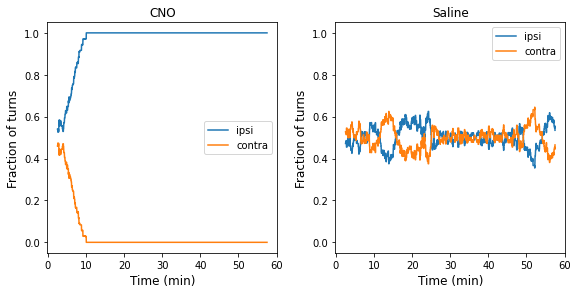

In [21]:
fps = 1 #frames per second
win = fps * 60 * 5 #rolling window size

cno_ipsi, cno_contra = moving_average(array=df1['turn_cno'], window=win) #run our custom-defined function on the CNO data
saline_ipsi, saline_contra = moving_average(array=df1['turn_sal'], window=win) #run our custom-defined function on the saline data

time = df1['time'][int(win/2):int(len(df1['time'])-(win/2))] #get timestamps corresponding to the midpoint of each moving window

fig = plt.figure(figsize=(8,4)) #generate a figure template

#plot the CNO data
axes0 = fig.add_axes([0,.05,.4,.8]) #add a subplot, specifying the left & bottom margins, and subplot width & height respectively
axes0.plot(time, cno_ipsi, label = 'ipsi') #plot the fraction of ipsilateral turns against time
axes0.plot(time, cno_contra, label = 'contra') #plot the fraction of contralateral turns against time
axes0.set_title('CNO') #set title of the subplot
axes0.set_ylabel('fraction of turns') #set a label for the y-axis
axes0.set_xlabel('time (min)') #set a label for the x-axis
axes0.set_ylim(-0.05,1.05) #set the range of the y-axis
axes0.legend() #add a legend to the plot

#plot the saline data
axes1 = fig.add_axes([0.5,.05,.4,.8]) #as before, but notice the difference in the parameter specifying the left margin
axes1.plot(time, saline_ipsi, label = 'ipsi')
axes1.plot(time, saline_contra, label = 'contra')
axes1.set_title('Saline')
axes1.set_ylabel('fraction of turns')
axes1.set_xlabel('time (min)')
axes1.set_ylim(-0.05,1.05)
axes1.legend()

**Q-1.1. What is the reason for doing the experiment with saline?**

**Q-1.2. Look at the CNO plot. Why is there a gradual change in the fraction of turns at the beginning of the session?** (hint: think about the route of CNO administration)

### Task 2: examine data from all sessions with neuronal activation
The same experiment was performed with twelve mice. Each mouse performed three sessions with CNO and three sessions with saline. We will analyse only the final 10 minutes of each session to ensure that the effect of our experimental treatment has reached a plateau (see Task 1 for why this is a good idea).

Here we load data from all mice and all sessions.

As before, we examine the data table by calling `head()`.

In [2]:
path = SPATH + "Gi_hM3Dq_summarised.csv"
df2 = pd.read_csv(path, sep = ';')
df2.head()

,exp_type,mouse_id,session,turn_count
0,sal_ipsi,166.1,1,8
1,sal_ipsi,166.1,2,17
2,sal_ipsi,166.1,3,8
3,sal_ipsi,166.2,1,0
4,sal_ipsi,166.2,2,16


This dataset looks different. Column `turn_count` contains the total number of turns observed in the time window (the last 10 minutes) from each session that we wish to analyse.

Note that we are only seeing the first five rows of our data table. To understand our dataset better, let us have a look at the range of values in each column.

In [3]:
print('Types of experiment:', np.unique(df2['exp_type']))
print('Mice:', np.unique(df2['mouse_id']))
print('Sessions:', np.unique(df2['session']))

Types of experiment: ['cno_contra' 'cno_ipsi' 'sal_contra' 'sal_ipsi']
Mice: [166.1 166.2 166.3 167.1 167.2 167.3 168.1 168.2 168.3 169.1 169.2 169.3]
Sessions: [1 2 3]


This verifies that we are still dealing with the same two types of experiment (CNO and saline), and the same two possible outcomes (ipsilateral and contralateral turns). We also see the IDs of all twelve mice used in the experiment, and that each mouse completed up to three sessions.

Next we will summarise the data using [boxplots](https://seaborn.pydata.org/_images/seaborn-boxplot-2.png). The advantage of boxplots (over [barplots](https://seaborn.pydata.org/_images/seaborn-barplot-1.png), for example) is that they provide an indication of the spread of the data and point out any outliers.

In our boxplot, we want each data point to signify the number of turns per mouse averaged across the three sessions. Therefore, we define another custom function `get_average_per_mouse` that uses `for` loops to iterate over mouse IDs and experiment types to calculate the mean value for each `mouse_id/exp_type` pair.

In [0]:
def get_average_per_mouse(array):
  summarised_data = [] #create an empty list to store our computed values in
  labels = [] #create an empty list to store the correspond exp_type labels in

  # run a loop to iterate over mouse IDs
  for mouse in np.unique(array['mouse_id']):
    data = array[array['mouse_id'] == mouse] #get the subset of data from a given mouse
    
    #iterate over experiment types and compute the average value per type
    aves_per_mouse = [np.mean(data[data['exp_type'] == exp]['turn_count']) for exp in np.unique(data['exp_type'])]
    
    summarised_data.append(aves_per_mouse) #store the computed values
    labels.append(list(np.unique(data['exp_type']))) #store the corresponding 'exp_type' labels

  return (np.array(summarised_data), np.array(labels)) #return the average values and their corresponing 'exp_type' labels

Now, let us run this function on our data, and inspect its output. 

In [10]:
df2summary, labels = get_average_per_mouse(df2)
print('data table:\n',df2summary)
print('shape:', np.shape(df2summary))

data table:
 [[  0.  36.   6.  11.]
 [  7.  15.   7.   7.]
 [  0.  79.   8.  11.]
 [  0.  35.  10.  16.]
 [  2.  96.  21.   2.]
 [  0. 108.   8.  10.]
 [  0.  36.   7.  16.]
 [  0.  32.  14.   8.]
 [  0.  63.  18.   4.]
 [  2.  61.   6.   7.]
 [  1.  16.  10.   2.]
 [  2.  45.  16.   9.]]
shape: (12, 4)


How do we make sense of this? We see that the data array contains 12 rows and 4 columns, corresponding to the number of mice and experiment types respectively. The order of mouse IDs and experiment types is the same across all rows and columns, and is determined by the `np.unique()` function we used inside our `get_average_per_mouse` function to extract unique values from our data for iteration purposes.

Notice that our function returns another array `labels` that contains the `exp_type` label corresponding to each data point. Below, we combine these two arrays in a DataFrame because it makes generation of boxplots very straightforward.

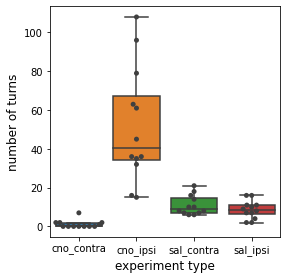

In [14]:
#combine the arrays into a DataFrame
df2boxplot = pd.DataFrame(zip(df2summary.flatten(),labels.flatten()), columns = ['number of turns','experiment type'])

fig = plt.figure(figsize=(4,4))
axes = fig.add_axes([0,.05,.8,.8])

#generate the boxplot
axes = sns.boxplot(x = 'experiment type', y = 'number of turns', data = df2boxplot, showfliers = True, fliersize = 1)

#add individual data points to the boxplot 
axes = sns.swarmplot(x = 'experiment type', y = "number of turns", data = df2boxplot, color = ".25")

**Q-2.1. Why might it be better to plot the average number of counts per mouse (one point per mouse) rather than the number of counts in each individual session (three points per mouse)?**

**Q-2.2. Based on the plot, what does artificial activation of Gi neurons on one side of the brain tell us about turning behaviour?**

Although one category clearly stands out, we cannot draw any conclusions yet. In science, we must always apply statistical analysis to determine if any two sets of data are _significantly different_. Although the details of statistical tests are beyond the scope of this tutorial, a few general ideas should be noted:
* statistical tests address a _null hypothesis_ which states that there is no significant difference between the data distributions of interest and that any observed differences are due to insufficient sampling or experimental error
* statistical tests produce a _test statistic_ which compares the data with what we would expect if the null hypothesis was true
* the likelihood that our data comes from the same distribution, _assuming that the null hypothesis is true_, is known as the _p-value_; you can think of it as the probability that, were you to repeat the experiment again and again, your data distributions would be at least as different from each other _if the null hypothesis is true_
* traditionally, distributions are considered statistically different if $p < 0.05$. This means that, if the null hypothesis was true and you repeated the experiment many times, the data distributions would be at least as different from each other as they are in your current experiment less than 5% of the time. Therefore, one may argue that the premise of the above statement _that the null hypothesis is true_ might not be true after all, and that the data distributions are statistically different
* the $p < 0.05$ threshold is arbitrary and widely considered to be too lenient, so a good rule of thumb is to confidently claim statistical significance only if the p-value is orders of magnitude below 5%

Whew! That is probably a lot to take in! Statistical analysis is by no means straightforward, and even well-seasoned scientists sometimes struggle. 

Let us see how this works in practice. 

To decide what statistical test to use, we must think about our data. For convenience of generating a boxplot, we have been talking about four experiment types. However, a more meaningful way to categorise our data would be to consider two types of treatment (CNO vs. saline) and two types of turn (ipsilateral vs. contralateral). The most appropriate statistical test for this type of comparison is two-way Analysis of Variance (ANOVA). It will generate p-values for the following three questions:
* the significance of treatment
* the significane of turning direction
* the significance of treatment-turning direction interaction (_this will be explained below_)

First we need to reorganise the data a little bit. You do not have to worry about the details in the code here.

In [64]:
#reorganise the data along with the appropriate treatment and turn labels into a new DataFrame
data = df2summary.T.flatten()
treatment = np.hstack((['cno']*int(len(data)/2), ['sal']*int(len(data)/2)))
turn = np.hstack((['contra']*int(len(data)/4), ['ipsi']*int(len(data)/4),['contra']*int(len(data)/4), ['ipsi']*int(len(data)/4)))
df2stats = pd.DataFrame(zip(data,treatment,turn), columns = ['data','treatment','turn'])

#run two-way ANOVA
formula = 'data ~ C(treatment) + C(turn) + C(treatment):C(turn)'
model = ols(formula, df2stats).fit()
aov_table = anova_lm(model, typ=2)

aov_table

,sum_sq,df,F,PR(>F)
C(treatment),3366.750000,1.0,14.128245,4.996085e-04
C(turn),7008.333333,1.0,29.409801,2.358196e-06
C(treatment):C(turn),8427.000000,1.0,35.363100,4.041647e-07
Residual,10485.166667,44.0,NaN,NaN


The three p-values are printed in the column labeled `PR(>F)`. As you can see, all three are much lower than our $p < 0.05$ threshold. Therefore:
* treatment (CNO vs saline) has a significant effect on the number of turns
* turn direction (ipsi vs contra) has a significant effect on the number of turns
* treatment-turn direction has a significant effect on the number of turns

The third statement is the most important one. It means that _the effect of turn direction depends on treatment_. If this interaction term is significant, the other two terms become irrelevant. In other words, interdependence of treatment and turn direction means that it no longer makes sense to consider the effects of these two factors separately.

The statistical analysis does not end here, however. We would also like to know exactly which categories are different from one another. To find that out, we will run statistical tests – Student's t-tests in this case – on all pairs of categories addressed by the interaction effect in the two-way ANOVA. 

In [67]:
#split the data into separate variables for convenience
cno_contra = df2boxplot[df2boxplot['experiment type'] == 'cno_contra']['number of turns']
cno_ipsi = df2boxplot[df2boxplot['experiment type'] == 'cno_ipsi']['number of turns']
sal_contra = df2boxplot[df2boxplot['experiment type'] == 'sal_contra']['number of turns']
sal_ipsi = df2boxplot[df2boxplot['experiment type'] == 'sal_ipsi']['number of turns']

ttests = {} #create another empty dictionary to store the p values in

#run t-tests to test how the effect of turn direction depends on treatment
ttests['cno_contra_and_cno_ipsi'] = scipy.stats.ttest_ind(cno_contra, cno_ipsi)[1]
ttests['sal_contra_and_sal_ipsi'] = scipy.stats.ttest_ind(sal_contra, sal_ipsi)[1]

#run t-test to test how the effect of treatment depends on turn direction
ttests['cno_contra_and_sal_contra'] = scipy.stats.ttest_ind(cno_contra, sal_contra)[1]
ttests['cno_ipsi_and_sal_ipsi'] = scipy.stats.ttest_ind(cno_ipsi, sal_ipsi)[1]

ttests

{'cno_contra_and_cno_ipsi': 7.223429637181469e-06,
 'cno_contra_and_sal_contra': 3.3530644334036876e-06,
 'cno_ipsi_and_sal_ipsi': 6.22611933556348e-05,
 'sal_contra_and_sal_ipsi': 0.25312834118835753}

These are some pretty small p-values. Unfortunately though, this is still not enough. 

Our $p < 0.05$ significance threshold means that, in any given statistical test, there is a 5% probability of getting a "significant" result simply by chance. Therefore, if we ran statistical tests on a hundred pairs of categories, it is likely that five of our tests would turn out "significant" just by chance too. To avoid such false positives, we must adjust our signficance threshold. In other words, we must require a lower p-value to consider a result significant. 

One approach is called a Bonferroni multiple comparisons test, and we apply that below.

In [68]:
#compute the Bonferroni-adjusted p-values
adjusted = multipletests(pvals = list(ttests.values()), alpha = 0.05, method = 'bonferroni')

#arrange these p-values in a table for convenient inspection
ttests_corrected = pd.DataFrame(zip(ttests.keys(), adjusted[0], adjusted[1]), columns = ['comparison','significance','p-value'])

ttests_corrected

,comparison,significance,p-value
0,cno_contra_and_cno_ipsi,True,0.000029
1,sal_contra_and_sal_ipsi,False,1.000000
2,cno_contra_and_sal_contra,True,0.000013
3,cno_ipsi_and_sal_ipsi,True,0.000249


**Q-2.3. What do these four p-values tell us about our results? How does it compare with your expectations?**

##Experiment 2: chemogenetic inhibition of specific Gi neurons

A complementary way for investigating the role of genetically defined Gi neurons in turning behaviour is to artificially inhibit those neurons during the same cylinder assay as before. There are many ways to achieve neuronal inhibition, differing by the timescale of their action. 

In the seminar, we saw the use of diphtheria toxin to permanently 'inhibit' neurons. Here, mice were made to express a specific receptor (hM4Di) selectively in the Gi neurons of interest on _one side_ (right side) of the brain. As you might guess based on the name of this receptor, it is quite similar to the one used to activate neurons in Experiment 1. Indeed, this receptor is also sensitive to CNO. Yet, subtle differences in its biochemical structure mean that, upon activation by CNO, this receptor inhibits the neurons it is expressed in, making them less likely to fire action potentials.

As before, the mouse was injected with saline instead of CNO in some sessions. Video data was preprocessed as before.

### Task 3: examine data from all sessions with neuronal inhibition
Twelve other mice individually performed six sessions in the cylinder: three sessions with CNO and three sessions with saline. We will analyse only the final 10 minutes of each session as before.

Here we load data from all mice and all sessions like in Task 2. 

We analyse data in the exact same manner. You will therefore be asked to type in some lines of code yourself. Do not fear though! All you need to do is find the analogous part of code in Task 2 and change the names of a few variables.

**Before you procede, make sure you have run the `get_average_per_mouse` function that we defined in Task 2!**

In [8]:
path = SPATH + "Gi_hM4Di_summarised.csv"
df3 = pd.read_csv(path, sep = ';')
df3.head()

,exp_type,mouse_id,session,turn_count
0,sal_ipsi,166.1,1,8
1,sal_ipsi,166.1,2,11
2,sal_ipsi,166.1,3,11
3,sal_ipsi,166.2,1,17
4,sal_ipsi,166.2,2,18


In [0]:
#average the data per mouse across sessions
df3summary, labels = get_average_per_mouse(df3)

#combine the arrays into a DataFrame
df3boxplot = pd.DataFrame(zip(df3summary.flatten(),labels.flatten()), columns = ['number of turns','experiment type'])

**Complete two lines of code below to generate a boxplot and add data points to the plot as we did in Task 2!**

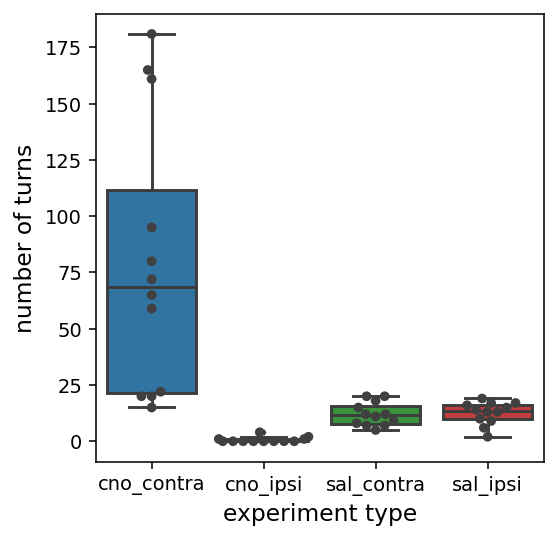

In [9]:
fig = plt.figure(figsize=(4,4))
axes = fig.add_axes([0,.05,.8,.8])

#generate the boxplot
axes = 

#add individual data points to the boxplot 
axes = 

**Q-3.1. How is this plot different from that in Task 2? Can you explain why?**

Let us continue by running the same statistical tests as above. You do not need to write any code in this section.

In [10]:
#reorganise the data along with the appropriate treatment and turn labels into a new DataFrame
data = df3summary.T.flatten()
treatment = np.hstack((['cno']*int(len(data)/2), ['sal']*int(len(data)/2)))
turn = np.hstack((['contra']*int(len(data)/4), ['ipsi']*int(len(data)/4),['contra']*int(len(data)/4), ['ipsi']*int(len(data)/4)))
df3stats = pd.DataFrame(zip(data,treatment,turn), columns = ['data','treatment','turn'])

#run two-way ANOVA
formula = 'data ~ C(treatment) + C(turn) + C(treatment):C(turn)'
model = ols(formula, df3stats).fit()
aov_table = anova_lm(model, typ=2)

aov_table

,sum_sq,df,F,PR(>F)
C(treatment),9296.333333,1.0,10.145186,0.002659
C(turn),18408.333333,1.0,20.089206,0.000052
C(treatment):C(turn),18960.750000,1.0,20.692064,0.000042
Residual,40318.500000,44.0,NaN,NaN


**Q-3.2. What can you learn from the p-values produced by this two-way ANOVA test?**

In [0]:
#split the data into separate variables for convenience
cno_contra = df3boxplot[df3boxplot['experiment type'] == 'cno_contra']['number of turns']
cno_ipsi = df3boxplot[df3boxplot['experiment type'] == 'cno_ipsi']['number of turns']
sal_contra = df3boxplot[df3boxplot['experiment type'] == 'sal_contra']['number of turns']
sal_ipsi = df3boxplot[df3boxplot['experiment type'] == 'sal_ipsi']['number of turns']

ttests = {} #create another empty dictionary to store the p values in

#run t-tests to test how the effect of turn direction depends on treatment
ttests['cno_contra_and_cno_ipsi'] = scipy.stats.ttest_ind(cno_contra, cno_ipsi)[1]
ttests['sal_contra_and_sal_ipsi'] = scipy.stats.ttest_ind(sal_contra, sal_ipsi)[1]

#run t-test to test how the effect of treatment depends on turn direction
ttests['cno_contra_and_sal_contra'] = scipy.stats.ttest_ind(cno_contra, sal_contra)[1]
ttests['cno_ipsi_and_sal_ipsi'] = scipy.stats.ttest_ind(cno_ipsi, sal_ipsi)[1]

In [13]:
#compute the Bonferroni-adjusted p-values
adjusted = multipletests(pvals = list(ttests.values()), alpha = 0.05, method = 'bonferroni')

#arrange these p-values in a table for convenient inspection
ttests_corrected = pd.DataFrame(zip(ttests.keys(), adjusted[0], adjusted[1]), columns = ['comparison','significance','p-value'])

ttests_corrected

,comparison,significance,p-value
0,cno_contra_and_cno_ipsi,True,6.329531e-04
1,sal_contra_and_sal_ipsi,False,1.000000e+00
2,cno_contra_and_sal_contra,True,3.222897e-03
3,cno_ipsi_and_sal_ipsi,True,2.275270e-07


**Q-3.3. Based on your plot and these p-values, what does artificial inhibition of Gi neurons on one side of the brain tell us about turning behaviour?**

## Conclusions
Well done on completing this tutorial! In many cases, analysing data takes up the majority of neuroscientists' daily lives, and now you have had a (hopefully enjoyable) glimpse into those!

At the end of analysis, it is always important to bring all experiments together and consider the bigger picture.

**Q-4.1. What can you conclude about the involvement of Gi neurons in turning behaviour based on both experiments in this tutorial?**

**Q-4.2. Can you suggest any other experiments that should be done to further validate your current conclusions?**

**Q-4.3. As an aspiring systems neuroscientist, what else might you want to learn about the neural circuits mediating turning behaviour to be able to claim a full understanding of how the central nervous system makes us turn right or left?**

I hope you had fun doing this tutorial. See you in the follow-up session!